In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,LSTM
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from datetime import datetime
from matplotlib import pyplot

In [ ]:
# Cargando el conjunto de Datos
df = pd.read_csv('Ocupacion-Uci.csv',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['Fecha','Camas UCI Ocupadas Covid-19'])
df.head()

Fecha
2020-08-04    106
2020-09-04    136
2020-10-04    150
2020-11-04    148
2020-12-04    178
Name: Camas UCI Ocupadas Covid-19, dtype: int64

In [ ]:
df.describe()

count     479.000000
mean     1149.198330
std       599.819269
min       106.000000
25%       792.000000
50%      1036.000000
75%      1569.000000
max      2224.000000
Name: Camas UCI Ocupadas Covid-19, dtype: float64

In [ ]:
print(df.index.min())
print(df.index.max())

2020-01-05 00:00:00
2021-12-07 00:00:00


In [ ]:
print(len(df['2020']))
print(len(df['2021']))

267
212


In [ ]:
meses =df.resample('M').mean()
meses

Fecha
2020-01-31     798.375000
2020-02-29     797.750000
2020-03-31     803.750000
2020-04-30     350.961538
2020-05-31     410.925926
2020-06-30     611.115385
2020-07-31    1133.444444
2020-08-31    1233.259259
2020-09-30     872.888889
2020-10-31     793.035714
2020-11-30     779.000000
2020-12-31     967.964286
2021-01-31    1752.807692
2021-02-28    1197.173913
2021-03-31     995.500000
2021-04-30    1631.680000
2021-05-31    1961.115385
2021-06-30    2017.120000
2021-07-31    1542.653846
2021-08-31    1598.142857
2021-09-30    1602.857143
2021-10-31    1603.428571
2021-11-30    1601.857143
2021-12-31    1599.285714
Freq: M, Name: Camas UCI Ocupadas Covid-19, dtype: float64

## Preparación de los datos LSTM

In [ ]:
PASOS=7

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-1.000000,-0.971671,-0.958451,-0.960340,-0.932011,-0.955619,-0.966006,-0.951841
8,-0.971671,-0.958451,-0.960340,-0.932011,-0.955619,-0.966006,-0.951841,-0.958451
9,-0.958451,-0.960340,-0.932011,-0.955619,-0.966006,-0.951841,-0.958451,-0.977337
10,-0.960340,-0.932011,-0.955619,-0.966006,-0.951841,-0.958451,-0.977337,-0.970727
11,-0.932011,-0.955619,-0.966006,-0.951841,-0.958451,-0.977337,-0.970727,-0.969783


## Dividimos el conjunto de entrenamiento y validación

In [ ]:
# split into train and test sets
values = reframed.values
n_train_days = 369
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(369, 1, 7) (369,) (103, 1, 7) (103,)


## Creamos la red neuronal

In [ ]:
def crear_modeloLSTM():
    model = Sequential() 
    model.add(LSTM(7, return_sequences=True, input_shape=(1,PASOS),activation='tanh'))
    model.add(LSTM(5, return_sequences=True, activation='tanh'))
    model.add(LSTM(3, return_sequences=True, activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model
  

In [ ]:
EPOCHS=40

model = crear_modeloLSTM()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 7)              420       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 5)              260       
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 3)              108       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
53/53 [==============================] - 7s 29ms/step - loss: 0.3707 - mse: 0.2032 - val_loss: 0.8257 - val_mse

## Visualización de Resultados

103


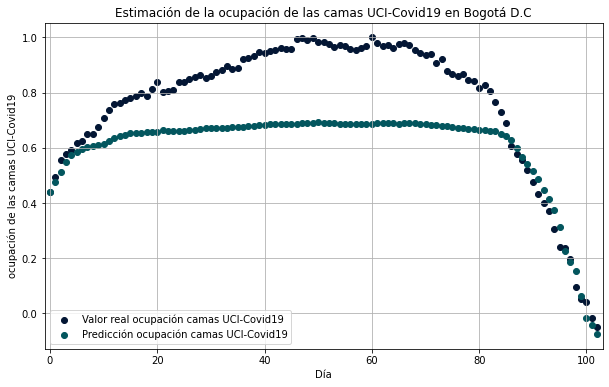

In [ ]:
results=model.predict(x_val)
print( len(results) )
plt.figure(figsize=(10,6))
plt.scatter(range(len(y_val)),y_val,color="#031634",label="Valor real ocupación camas UCI-Covid19")
plt.scatter(range(len(results)),results,color="#03565E",label="Predicción ocupación camas UCI-Covid19")
plt.title('Estimación de la ocupación de las camas UCI-Covid19 en Bogotá D.C')
plt.xlabel('Día')
plt.ylabel('ocupación de las camas UCI-Covid19')
plt.legend()
plt.xlim(-1,103)
plt.grid()
plt.show()

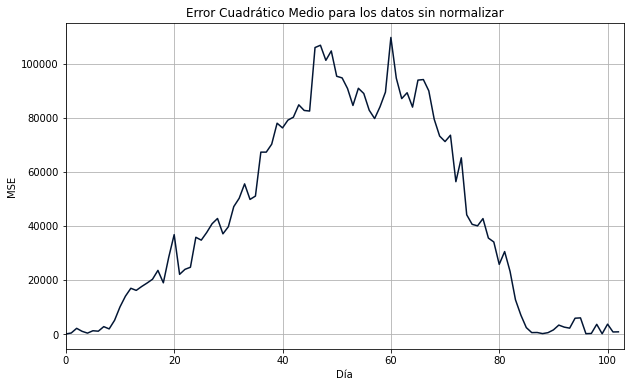

In [ ]:
n=len(results)
MSE=np.zeros(n)
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
MSEsum=0
for i in range(0,len(results)):
  MSE[i] = (compara2['real'][i] - compara2['prediccion'][i])**2
  MSEsum = np.sum(MSE)/n
plt.figure(figsize=(10,6))
plt.plot(range(len(results)),MSE, color="#031634")
plt.title('Error Cuadrático Medio para los datos sin normalizar')
plt.xlabel('Día')
plt.ylabel('MSE')
plt.xlim(0,103)
plt.grid()
plt.show()

In [ ]:
print('El MSE es de %0.3f' % MSEsum)

El MSE es de 42993.894


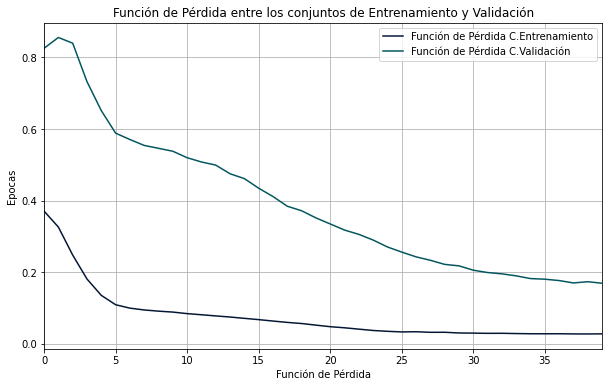

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color="#031634",label="Función de Pérdida C.Entrenamiento")
plt.plot(history.history['val_loss'], color="#03565E" ,label="Función de Pérdida C.Validación")
plt.title('Función de Pérdida entre los conjuntos de Entrenamiento y Validación')
plt.xlabel('Función de Pérdida')
plt.ylabel('Epocas')
plt.legend()
plt.grid()
plt.xlim(0,39)
plt.show()

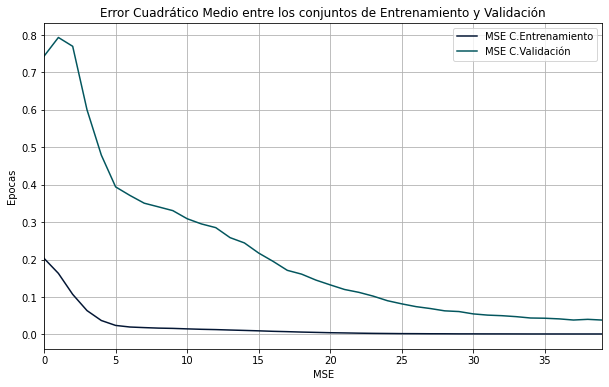

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['mse'], color="#031634", label="MSE C.Entrenamiento")
plt.plot(history.history['val_mse'], color="#03565E", label="MSE C.Validación")
plt.title('Error Cuadrático Medio entre los conjuntos de Entrenamiento y Validación')
plt.xlabel('MSE')
plt.ylabel('Epocas')
plt.legend()
plt.grid()
plt.xlim(0,39)
plt.show()

In [ ]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head(10)

,real,prediccion,diferencia
0,1632.0,1631.614746,0.385254
1,1687.0,1667.921753,19.078247
2,1754.0,1708.328491,45.671509
3,1776.0,1744.670776,31.329224
4,1792.0,1774.187012,17.812988
5,1818.0,1783.457153,34.542847
6,1828.0,1795.897461,32.102539
7,1854.0,1801.911377,52.088623
8,1852.0,1808.676025,43.323975
9,1881.0,1809.839478,71.160522


In [ ]:
compara2.describe()

,real,prediccion,diferencia
count,103.000000,103.000000,103.000000
mean,1973.281494,1803.797974,169.483994
std,268.451385,173.906769,120.037354
min,1114.000000,1085.878540,-77.167603
25%,1867.500000,1812.872986,56.198608
50%,2063.000000,1872.535645,192.444214
75%,2175.000000,1891.886414,282.034790
max,2224.000000,1898.269897,331.159546


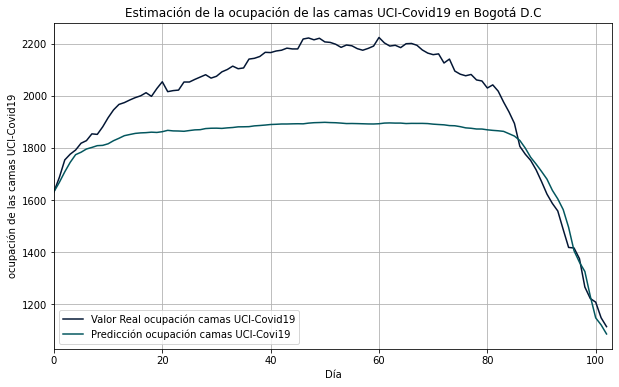

In [ ]:
plt.figure(figsize=(10,6))
compara2['real'].plot(color="#031634",label="Valor Real ocupación camas UCI-Covid19")
compara2['prediccion'].plot( color="#03565E",label="Predicción ocupación camas UCI-Covi19")
plt.title('Estimación de la ocupación de las camas UCI-Covid19 en Bogotá D.C')
plt.xlabel('Día')
plt.ylabel('ocupación de las camas UCI-Covid19')
plt.legend()
plt.xlim(0,103)
plt.grid()
plt.show()

## PRONOSTICO
A partir de los últimos tres meses del 2021, intentaremos predecir el mes de Agosto.

In [ ]:
ultimosDias = df['2021-07-01':'2021-07-31']
ultimosDias

Fecha
2021-07-01    1539
2021-07-02    1382
2021-07-03     874
2021-07-04    1051
2021-07-05    2012
2021-07-06    2215
2021-07-07    2061
2021-07-13    1938
2021-07-14    1894
2021-07-15    1806
2021-07-16    1776
2021-07-17    1752
2021-07-18    1716
2021-07-19    1671
2021-07-20    1623
2021-07-21    1587
2021-07-22    1558
2021-07-23    1487
2021-07-24    1418
2021-07-25    1416
2021-07-26    1375
2021-07-27    1266
2021-07-28    1222
2021-07-29    1208
2021-07-30    1148
2021-07-31    1114
Name: Camas UCI Ocupadas Covid-19, dtype: int64

## Preparamos los datos para Test

In [ ]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.008203,-0.242357,-1.000000,-0.736018,0.697241,1.000000,0.770320
8,-0.242357,-1.000000,-0.736018,0.697241,1.000000,0.770320,0.586875
9,-1.000000,-0.736018,0.697241,1.000000,0.770320,0.586875,0.521253
10,-0.736018,0.697241,1.000000,0.770320,0.586875,0.521253,0.390007
11,0.697241,1.000000,0.770320,0.586875,0.521253,0.390007,0.345265
12,1.000000,0.770320,0.586875,0.521253,0.390007,0.345265,0.309470
13,0.770320,0.586875,0.521253,0.390007,0.345265,0.309470,0.255779


In [ ]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(13, 1, 7)


array([[[ 0.7703204 ,  0.5868752 ,  0.52125263,  0.39000726,
          0.34526467,  0.30947042,  0.25577903]],

       [[ 0.5868752 ,  0.52125263,  0.39000726,  0.34526467,
          0.30947042,  0.25577903,  0.18866491]],

       [[ 0.52125263,  0.39000726,  0.34526467,  0.30947042,
          0.25577903,  0.18866491,  0.11707664]],

       [[ 0.39000726,  0.34526467,  0.30947042,  0.25577903,
          0.18866491,  0.11707664,  0.06338549]],

       [[ 0.34526467,  0.30947042,  0.25577903,  0.18866491,
          0.11707664,  0.06338549,  0.02013397]],

       [[ 0.30947042,  0.25577903,  0.18866491,  0.11707664,
          0.06338549,  0.02013397, -0.08575702]],

       [[ 0.25577903,  0.18866491,  0.11707664,  0.06338549,
          0.02013397, -0.08575702, -0.18866539]],

       [[ 0.18866491,  0.11707664,  0.06338549,  0.02013397,
         -0.08575702, -0.18866539, -0.19164824]],

       [[ 0.11707664,  0.06338549,  0.02013397, -0.08575702,
         -0.18866539, -0.19164824, -0.25279

In [ ]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

## Pronóstico para el próximo mes

In [ ]:
results=[]
for i in range(31):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[ 0.7703204   0.5868752   0.52125263  0.39000726  0.34526467
    0.30947042  0.25577903]]

 [[ 0.5868752   0.52125263  0.39000726  0.34526467  0.30947042
    0.25577903  0.18866491]]

 [[ 0.52125263  0.39000726  0.34526467  0.30947042  0.25577903
    0.18866491  0.11707664]]

 [[ 0.39000726  0.34526467  0.30947042  0.25577903  0.18866491
    0.11707664  0.06338549]]

 [[ 0.34526467  0.30947042  0.25577903  0.18866491  0.11707664
    0.06338549  0.02013397]]

 [[ 0.30947042  0.25577903  0.18866491  0.11707664  0.06338549
    0.02013397 -0.08575702]]

 [[ 0.25577903  0.18866491  0.11707664  0.06338549  0.02013397
   -0.08575702 -0.18866539]]

 [[ 0.18866491  0.11707664  0.06338549  0.02013397 -0.08575702
   -0.18866539 -0.19164824]]

 [[ 0.11707664  0.06338549  0.02013397 -0.08575702 -0.18866539
   -0.19164824 -0.25279665]]

 [[ 0.06338549  0.02013397 -0.08575702 -0.18866539 -0.19164824
   -0.25279665 -0.41536176]]

 [[ 0.02013397 -0.08575702 -0.18866539 -0.19164824 -0.25279665
   -0.4

In [ ]:
# Re-Convertimos los resultados
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([0.14194761], dtype=float32), array([0.08463611], dtype=float32), array([-0.01320311], dtype=float32), array([-0.07633838], dtype=float32), array([-0.16393279], dtype=float32), array([-0.23229471], dtype=float32), array([-0.300606], dtype=float32), array([-0.34151712], dtype=float32), array([-0.39562586], dtype=float32), array([-0.4300066], dtype=float32), array([-0.47261584], dtype=float32), array([-0.50093764], dtype=float32), array([-0.5338623], dtype=float32), array([-0.5587532], dtype=float32), array([-0.5904063], dtype=float32), array([-0.6138933], dtype=float32), array([-0.6423104], dtype=float32), array([-0.66506624], dtype=float32), array([-0.6906308], dtype=float32), array([-0.7117716], dtype=float32), array([-0.73350525], dtype=float32), array([-0.7506212], dtype=float32), array([-0.76729596], dtype=float32), array([-0.77993804], dtype=float32), array([-0.7913384], dtype=float32), array([-0.7995338], dtype=float32), array([-0.80643654], dtype=float32), array([-0.81103

array([[1639.67597383],
       [1601.24860886],
       [1535.64741516],
       [1493.31521257],
       [1434.58316289],
       [1388.74649247],
       [1342.94376226],
       [1315.51286359],
       [1279.23295338],
       [1256.18067077],
       [1227.61117166],
       [1208.6214026 ],
       [1186.5454229 ],
       [1169.85607432],
       [1148.63266615],
       [1132.88465119],
       [1113.83097823],
       [1098.57317291],
       [1081.43214086],
       [1067.25722489],
       [1052.68481787],
       [1041.20857276],
       [1030.02814795],
       [1021.5516294 ],
       [1013.90769994],
       [1008.41268396],
       [1003.7843871 ],
       [1000.70105393],
       [ 998.22322919],
       [ 996.77925684],
       [ 995.70424058]])

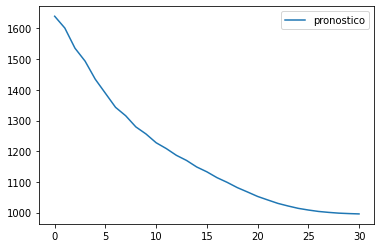

In [ ]:
prediccionAgostoUCI = pd.DataFrame(inverted)
prediccionAgostoUCI.columns = ['pronostico']
prediccionAgostoUCI.plot()
prediccionAgostoUCI.to_csv('pronostico.csv')

In [ ]:
prediccionAgostoUCI

,pronostico
0,1639.675974
1,1601.248609
2,1535.647415
3,1493.315213
4,1434.583163
5,1388.746492
6,1342.943762
7,1315.512864
8,1279.232953
9,1256.180671
